In [2]:
import warnings 
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import sys
import sklearn
import scipy
import math
import ast
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("../data/Kepler_FFI_Fits.csv")
params = pd.read_csv("../data/Kepler_FFI_Params.csv")

# all arrays in params imported as strings, convert them to actual arrays

for i in tqdm(params.index):
    for col in params.columns[1:]:
        lst = params[col][i]
        lst = ast.literal_eval(lst)
        params.at[i, col] = lst

  0%|          | 0/155070 [00:00<?, ?it/s]

In [4]:
# a model for a sine curve
def func(x, a, b, c, d):
    return a*np.sin(b * x + c) + d 

# a model for a straight line
def straightLine(x, m, b):
    return m*x + b

# a model for a sinecurve that is tiled on an axis
def func_tilt(x, a, b, c, d, e):
    return a*np.sin(b * x + c) + d + e*x

# a model for a straight line
def flatLine(x, b):
    return 0*x + b

In [5]:
# Visualize recorded light curves from FFI data and various fits

# the time points of all the data points in order
abs = [54945.74206,54945.8670833,54946.0182163,54946.2335259,54946.3377372,54946.5495655,54946.7334679,
         54947.1662509,55062.8253608,55091.0055606,55123.0864583,55153.9797114,55182.0366329,55215.9548927,
         55216.0352649,55245.7660019,55274.7398619,55307.5350333,55336.4281441,55370.695297,55399.0571196,
         55430.8109392,55461.8291274,55492.8064711,55522.7621353,55552.0843583,55585.5760016,55614.7389024,
         55677.4444762,55706.6440223,55738.4591443,55769.477399,55801.7624176,55832.8010616,55864.8001316,
         55895.757043,55930.8619526,55958.4268791,55986.5230115,56014.5579184,56047.5173675,56077.4525238,
         56105.5895974,56137.5273556,56168.8315615,56203.8547584,56236.834641,56267.9141396,56303.6729488,
         56330.563549,56357.495041,56390.4952381]
times = np.asarray(abs) - 54833

time = Time(abs, format='mjd')
normalized = time.decimalyear

cols = [str(i) for i in abs]

def visualize(kid, y_min = None, y_max = None):
    if kid not in df['KIC'].values:
        print("KIC does not have valid FFI data.")
    else:
        df_row = df[df['KIC'] == kid].iloc[0]
        params_row = params[params['KIC']== kid].iloc[0]
        
        x_plot = normalized
        y_plot = df_row[cols]
        
        plt.figure(figsize=(10, 10)) 
        ax = plt.axes()
        ax.errorbar(x_plot, y_plot, yerr=df_row[67:119], lw = 2, capsize = 4, capthick = 1, linestyle = '')
        scatter = ax.scatter(x_plot, y_plot, c=np.where(np.abs(df_row[123:len(df.columns) - 1].to_numpy()) < 3, True, False), cmap='PiYG')
        
        line_inp = np.linspace(times[0], times[-1], 500)
        line_plot = np.linspace(normalized[0], normalized[-1], 500)
        
        flat, = ax.plot(line_plot, flatLine(line_inp, params_row['flatLineParam']))
        straight, = ax.plot(line_plot, straightLine(line_inp, params_row['straightLineParam'][0], params_row['straightLineParam'][1]))
        curve, = ax.plot(line_plot, func(line_inp, params_row['curveParamL2'][0], params_row['curveParamL2'][1], params_row['curveParamL2'][2], params_row['curveParamL2'][3]))
        curtil, = ax.plot(line_plot, func_tilt(line_inp, params_row['curtilParamL2'][0], params_row['curtilParamL2'][1], params_row['curtilParamL2'][2], params_row['curtilParamL2'][3], params_row['curtilParamL2'][4]))
        
        # plt.axis('square')
        ax.set_xlabel('Year')
        ax.set_ylabel('Relative Flux')
        if (type(y_min) == int or type(y_min) == float) and (type(y_max) == int or type(y_max) == float):
            plt.ylim(y_min, y_max)
        ax.legend([flat, straight, curve, curtil], ['Flat Line', 'Straight Line', 'Curve', 'Tilted Curve'], loc='best')
        
        print("-- KIC: " + str(kid) + " --")
        plt.show()
        print("CP/CB: " + str(df_row['cpcb']))
        print("EB: " + str(df_row['eb']))
        print("Flat line L2 error: " + str(df_row['flatLineErrorL2']))
        print("Straight line L2 error: " + str(df_row['straightLineErrorL2']))
        print("Curve L2 error: " + str(df_row['curveErrorL2']))
        print("Tilted curve L2 error: " + str(df_row['curtilErrorL2']))
        print("Standard deviation: " + str(df_row['Standard_Deviation']) + "\n")

In [ ]:
imp = improvement(df, 'straightLineErrorL2', 'straightLineParam', 'curtilErrorL2', 'curtilParamL2')

# Plot straight vs curved fit error

data = imp

x_plot = data['straightLineErrorL2']
y_plot = data['curtilErrorL2']

plt.figure(figsize=(8, 8)) 

scatter = plt.scatter(x_plot, y_plot, c=data['eb'], cmap='viridis', s=2)
plt.legend(handles=scatter.legend_elements()[0], 
           labels=[0.0, 1.0],
           title="CP/CB Flag")
plt.xlabel('Flat Line Error L1')
plt.ylabel('Straight Line Error L1')

plt.xlim(0, 5000)
plt.ylim(0, 5000)

plt.show()

In [ ]:
# Print proportions of data that fit one curve better than another

err_labels = ['curveErrorL2',
        'straightLineErrorL2',
        'curtilErrorL2',
       'flatLineErrorL2']

par_labels = ['curveParamL2',
        'straightLineParam',
        'curtilParamL2',
        'flatLineParam']

for i in range(len(err_labels)):
    for j in range(len(err_labels)):
        if i != j:
            combo = improvement(df, err_labels[i], par_labels[i], err_labels[j], par_labels[j])
            print(err_labels[i])
            print(err_labels[j])
            print("df length: " + str(len(combo)))
            print("percentage eb: " + str(len(combo[combo['eb'] == 1]) / len(df[df['eb'] == 1])))
            print("percentage eb of data: " + str(len(combo[combo['eb'] == 1]) / len(combo)))
            print("percentage cpcb: " + str(len(combo[combo['cpcb'] == 1]) / len(df[df['cpcb'] == 1])))
            print("percentage cpcb of data: " + str(len(combo[combo['cpcb'] == 1]) / len(combo)) + "\n")

In [ ]:
# Find percentage of EBs for some # stdevs away (3+)

for i in range(-3, -8, -1):
    s = df
    repl = pd.DataFrame()
    for j in range(123, len(s.columns)):
        add = s[s.iloc[:, j] < i]
        repl = repl.append(add, ignore_index=True)
    print('percent eb: ' + str(len(repl[repl['eb'] == 1]) / len(df[df['eb'] == 1]) * 100))
    print('percent correct: ' + str(len(repl[repl['eb'] == 1]) / len(repl) * 100))
    print(len(repl))
    print()

In [ ]:
# Find outlying errors > 20000

l2 = ['flatLineErrorL2', 'straightLineErrorL2', 'curveErrorL2', 'curtilErrorL2']

rem = df.copy(deep=True)
for l in l2:
    rem = rem.drop(rem[rem[l] > 20000].index)
rem

In [ ]:
# Find percentage of data set that have large uncertainty measurements

vals = [0.1, 0.5, 1]
    
for val in vals:
    weird = pd.DataFrame()    

# big uncertainties
    for i in range(67, 119):
        add = df[df.iloc[:, i] > val]
        weird = weird.append(add, ignore_index=True)
        
    print(val)
    print(len(weird))
    print()

In [6]:
%run classify_types.ipynb

df = good()

print(len(long_term()))
print(len(mid_term()))
print(len(short_term()))
print(len(non_var()))
print(len(df[df['eb'] == 1]))
print(len(eb()))
print(len(df))
# nonvar 60-80%
print(len(non_var()) / len(df))

16770
955
27092
107817
2194
27320
152634
0.7063760367938992


In [12]:
len(df[df['Jitter'] == 0]) / len(df)

0.14235594163872453

In [109]:
st = long_term()

In [37]:
len(st[st['eb'] == 1]) / len(st)

0.05405511348045941

In [117]:
# white dwarf w accretion disk and a more massive star, cataclysmic binary star
st[st['KIC'] == 1026475.0]

,KIC,curveErrorL1,curveErrorL2,straightLineErrorL1,straightLineErrorL2,curtilErrorL1,curtilErrorL2,flatLineErrorL1,flatLineErrorL2,eb,cpcb,54945.74206,54945.8670833,54946.0182163,54946.2335259,54946.3377372,54946.5495655,54946.7334679,54947.1662509,55062.8253608,55091.0055606,55123.0864583,55153.9797114,55182.0366329,55215.9548927,55216.0352649,55245.7660019,55274.7398619,55307.5350333,55336.4281441,55370.695297,55399.0571196,55430.8109392,55461.8291274,55492.8064711,55522.7621353,55552.0843583,55585.5760016,55614.7389024,55677.4444762,55706.6440223,55738.4591443,55769.477399,55801.7624176,55832.8010616,55864.8001316,55895.757043,55930.8619526,55958.4268791,55986.5230115,56014.5579184,56047.5173675,56077.4525238,56105.5895974,56137.5273556,56168.8315615,56203.8547584,56236.834641,56267.9141396,56303.6729488,56330.563549,56357.495041,56390.4952381,uncert_new_0,uncert_new_1,uncert_new_2,uncert_new_3,mod_unc_new_00,mod_unc_new_01,mod_unc_new_02,mod_unc_new_03,mod_unc_new_04,mod_unc_new_05,mod_unc_new_06,mod_unc_new_07,mod_unc_new_08,mod_unc_new_09,mod_unc_new_10,mod_unc_new_11,mod_unc_new_12,mod_unc_new_13,mod_unc_new_14,mod_unc_new_15,mod_unc_new_16,mod_unc_new_17,mod_unc_new_18,mod_unc_new_19,mod_unc_new_20,mod_unc_new_21,mod_unc_new_22,mod_unc_new_23,mod_unc_new_24,mod_unc_new_25,mod_unc_new_26,mod_unc_new_27,mod_unc_new_28,mod_unc_new_29,mod_unc_new_30,mod_unc_new_31,mod_unc_new_32,mod_unc_new_33,mod_unc_new_34,mod_unc_new_35,mod_unc_new_36,mod_unc_new_37,mod_unc_new_38,mod_unc_new_39,mod_unc_new_40,mod_unc_new_41,mod_unc_new_42,mod_unc_new_43,mod_unc_new_44,mod_unc_new_45,mod_unc_new_46,mod_unc_new_47,mod_unc_new_48,mod_unc_new_49,mod_unc_new_50,mod_unc_new_51,Mean_Flux,Standard_Deviation,Average_Error,Jitter,sigma_1,sigma_2,sigma_3,sigma_4,sigma_5,sigma_6,sigma_7,sigma_8,sigma_9,sigma_10,sigma_11,sigma_12,sigma_13,sigma_14,sigma_15,sigma_16,sigma_17,sigma_18,sigma_19,sigma_20,sigma_21,sigma_22,sigma_23,sigma_24,sigma_25,sigma_26,sigma_27,sigma_28,sigma_29,sigma_30,sigma_31,sigma_32,sigma_33,sigma_34,sigma_35,sigma_36,sigma_37,sigma_38,sigma_39,sigma_40,sigma_41,sigma_42,sigma_43,sigma_44,sigma_45,sigma_46,sigma_47,sigma_48,sigma_49,sigma_50,sigma_51,sigma_52
71,1026475.0,19.717024,14.641777,21.894237,17.91773,17.241744,10.71299,30.13938,25.897298,0.0,0.0,1.000577,1.000726,1.000508,1.000823,1.000838,1.000818,0.999556,1.000755,1.001591,1.000656,1.001398,1.002122,1.001392,1.001908,1.003504,1.00098,1.00032,1.000432,1.000157,1.000038,1.000794,1.000288,0.999373,0.998885,1.000737,1.000325,1.0014,1.000051,1.000019,0.999404,0.999981,0.999747,1.0,0.998587,0.998245,0.999679,0.998164,0.999949,0.999338,0.998996,0.998956,0.998331,0.998893,0.999651,1.000043,0.998376,0.998671,1.000321,0.998764,0.999465,0.99842,0.998586,0.001,0.001,0.001,0.001,0.000805,0.00072,0.000957,0.000706,0.000822,0.000715,0.000688,0.000902,0.0019,0.00215,0.002211,0.0015,0.001941,0.0021,0.002028,0.00156,0.001938,0.001572,0.001392,0.002479,0.001694,0.000734,0.00166,0.001236,0.000784,0.000982,0.001999,0.000784,0.001448,0.00164,0.002731,0.002021,0.000662,0.001461,0.001607,0.000901,0.00147,0.001799,0.000793,0.002294,0.002238,0.002513,0.002534,0.002656,0.001002,0.001676,0.002591,0.001595,0.001752,0.002025,0.001603,0.002739,1.00003,0.001108,0.001605,0.0,0.493579,0.628814,0.431529,0.715798,0.729827,0.711227,-0.427565,0.654524,1.408922,0.564996,1.235081,1.888464,1.22902,1.694792,3.135407,0.857265,0.26202,0.362983,0.114843,0.007644,0.689757,0.233241,-0.592194,-1.032402,0.638638,0.266499,1.236883,0.019763,-0.009703,-0.564827,-0.043613,-0.254589,-0.026658,-1.302084,-1.610065,-0.316414,-1.683742,-0.073079,-0.623823,-0.932631,-0.969063,-1.532773,-1.025398,-0.341875,0.01237,-1.492211,-1.22564,0.263098,-1.142365,-0.509652,-1.452216,-1.302402


In [ ]:
# jitter < 0.001 = non var?

In [9]:
len(df[df['Jitter'] < 0.001])

39025

27320
-- KIC: 10010646.0 --


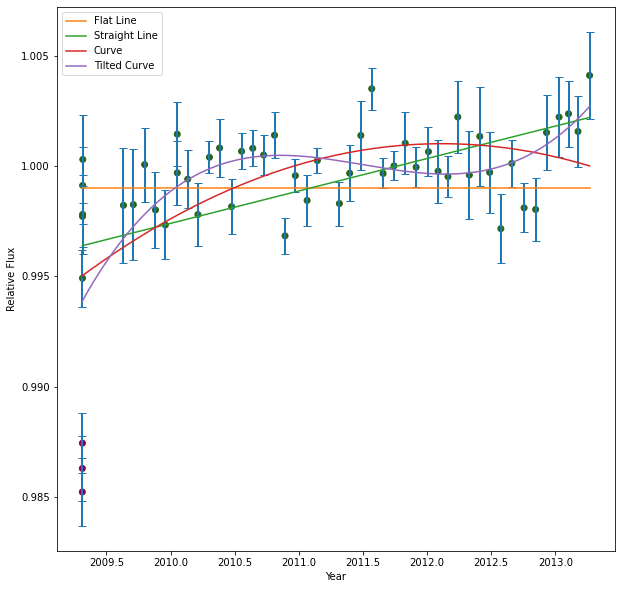

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 343.713906135608
Straight line L2 error: 272.6675658758782
Curve L2 error: 223.66303583902203
Tilted curve L2 error: 184.049182308539
Standard deviation: 0.0

-- KIC: 10141466.0 --


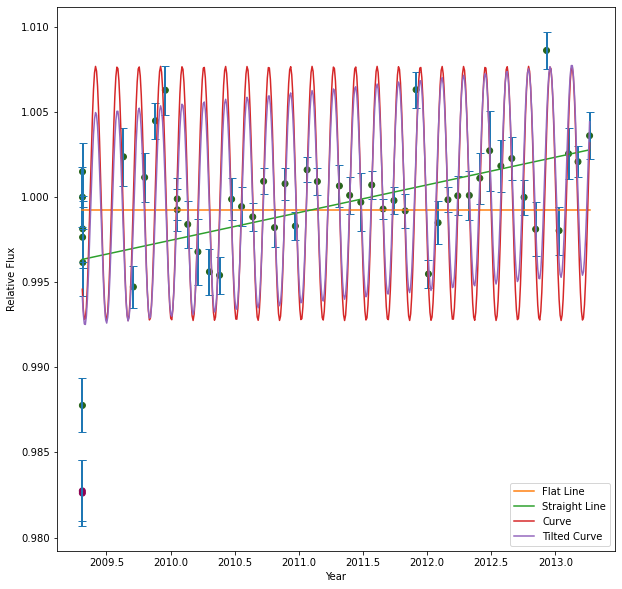

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 515.0616016690558
Straight line L2 error: 441.1443207366264
Curve L2 error: 319.6124717065816
Tilted curve L2 error: 298.13098828670434
Standard deviation: 0.0

-- KIC: 10208866.0 --


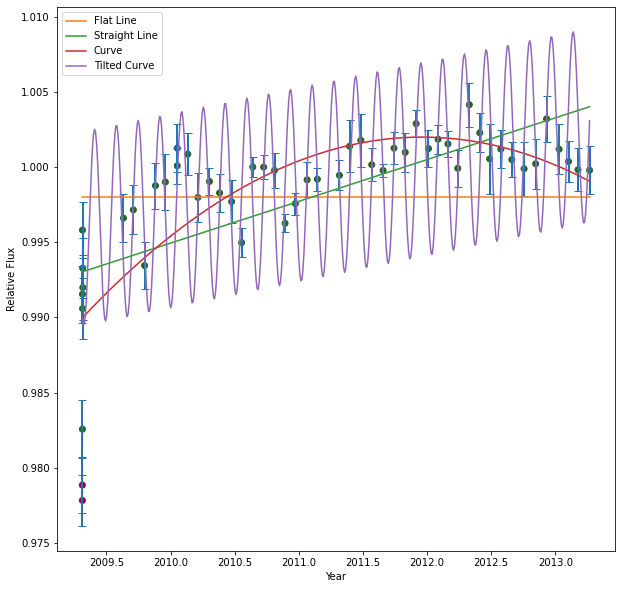

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 590.7390652485999
Straight line L2 error: 362.4118521412032
Curve L2 error: 296.44991404128643
Tilted curve L2 error: 268.84965389431324
Standard deviation: 0.0

-- KIC: 5955321.0 --


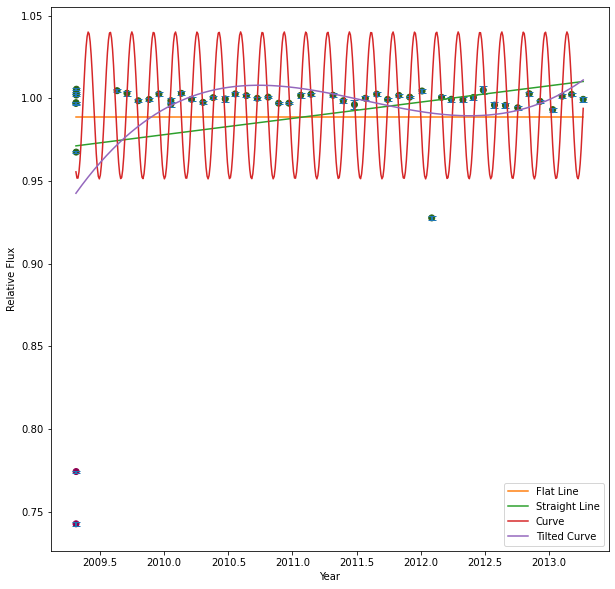

CP/CB: 0.0
EB: 1.0
Flat line L2 error: 167600.80202196835
Straight line L2 error: 154112.73246214155
Curve L2 error: 144806.78083391365
Tilted curve L2 error: 142452.24945171978
Standard deviation: 0.0

-- KIC: 8817510.0 --


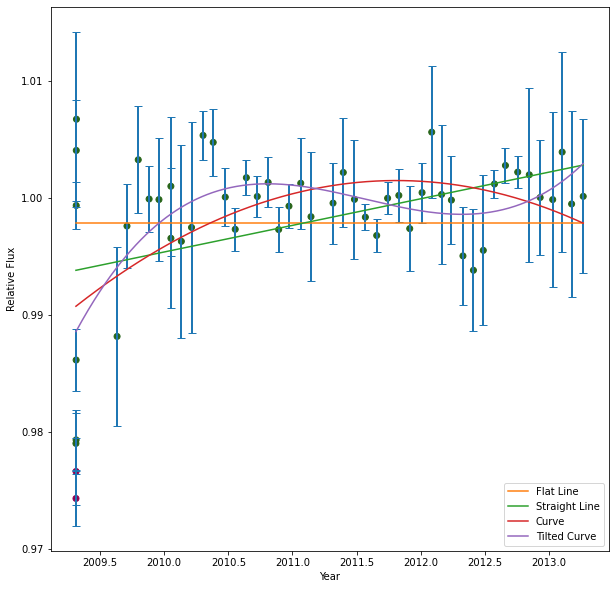

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 361.4532092310855
Straight line L2 error: 265.5239059075431
Curve L2 error: 218.2635989904348
Tilted curve L2 error: 178.31415404566886
Standard deviation: 0.0

-- KIC: 8884985.0 --


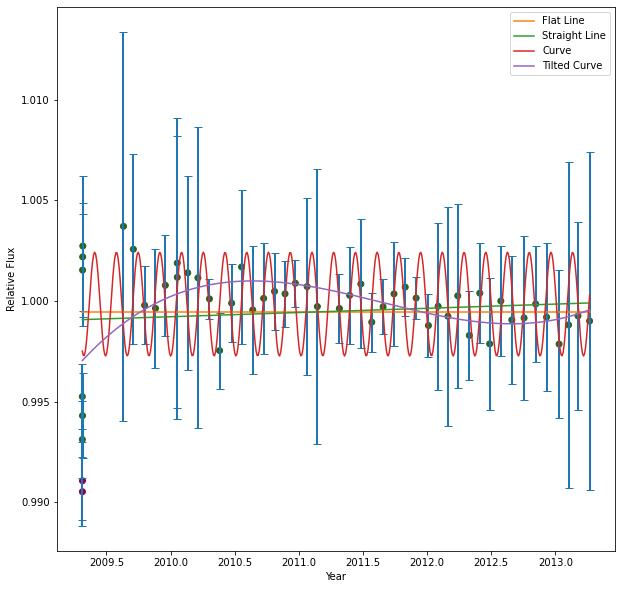

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 80.33469885573294
Straight line L2 error: 74.705963209096
Curve L2 error: 52.686950392530406
Tilted curve L2 error: 48.31210502077469
Standard deviation: 0.0

-- KIC: 8935352.0 --


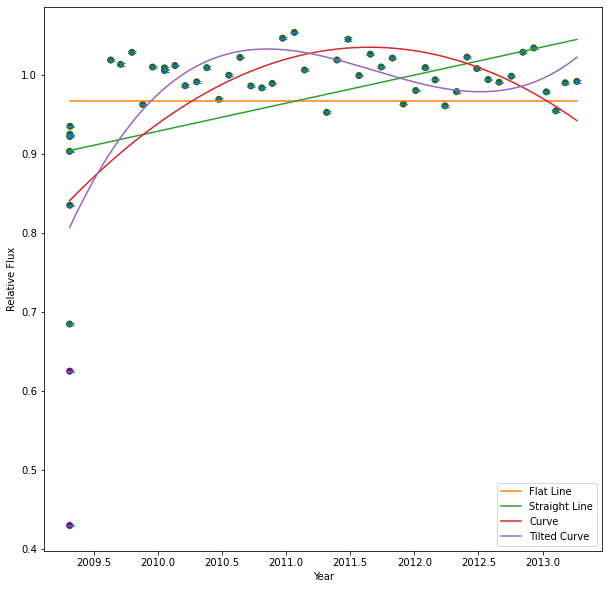

CP/CB: 0.0
EB: 1.0
Flat line L2 error: 962171.7083821684
Straight line L2 error: 728321.1042744068
Curve L2 error: 543433.9734322709
Tilted curve L2 error: 470270.5508598058
Standard deviation: 0.0

-- KIC: 10010646.0 --


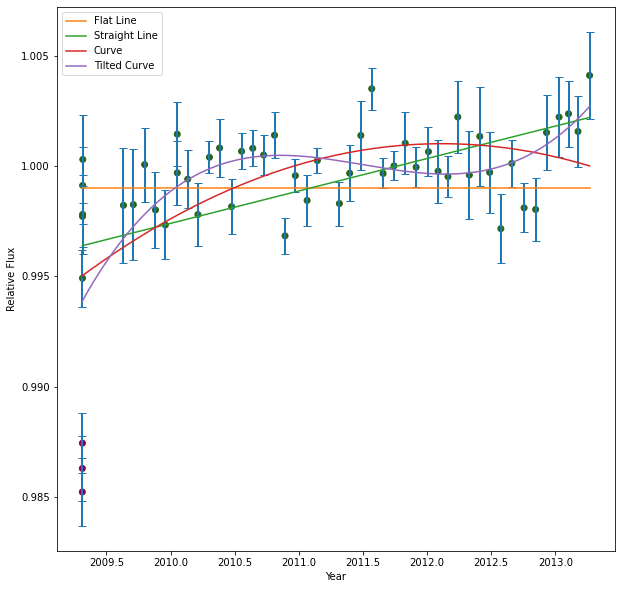

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 343.713906135608
Straight line L2 error: 272.6675658758782
Curve L2 error: 223.66303583902203
Tilted curve L2 error: 184.049182308539
Standard deviation: 0.0

-- KIC: 10010990.0 --


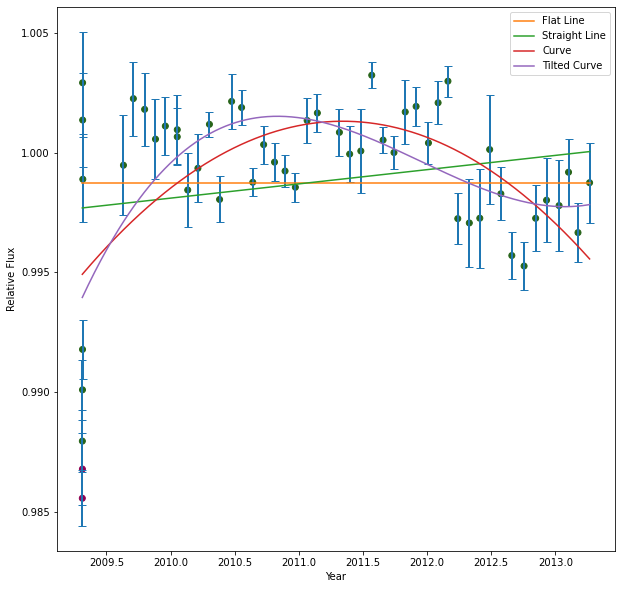

CP/CB: 0.0
EB: 0.0
Flat line L2 error: 641.0320839569687
Straight line L2 error: 601.2236999857143
Curve L2 error: 343.06531242735053
Tilted curve L2 error: 345.2001971332733
Standard deviation: 0.0



In [16]:
# Visualize plots

i = 0
data = eb()
# data = data[data['eb'] == 0]
print(len(data))
for kic in data['KIC']:
    # visualize(kic)
    if i > 10 and i < 20:
        visualize(kic)
    i += 1